# Differential poly(A) tail lengths

In this notebook we plot the poly(A) tail length (estimate) distribution for CAB1

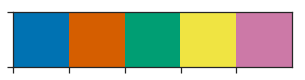

In [1]:
import sys
import os
from glob import glob
import random
from collections import Counter

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib_venn as vn
from matplotlib.colors import ListedColormap
import seaborn as sns

import pysam

## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=1.5, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [10]:
vir1_pa_dists = pd.read_csv(
    '../pooled/vir1_vs_col0_differential_polya_dists.tsv',
    sep='\t',
    names=['chrom', 'start', 'end', 'gene_id',
           'score', 'strand', 'nreads_vir1', 'nreads_col0',
           'median_vir1', 'ci_lower_vir1', 'ci_upper_vir1',
           'median_col0', 'ci_lower_col0', 'ci_upper_col0',
           'ks', 'ks_p_val', 'ks_fdr',
           'mwu', 'mwu_p_val', 'mwu_fdr']
)

vir1_pa_dists.head()

,chrom,start,end,gene_id,score,strand,nreads_vir1,nreads_col0,median_vir1,ci_lower_vir1,ci_upper_vir1,median_col0,ci_lower_col0,ci_upper_col0,ks,ks_p_val,ks_fdr,mwu,mwu_p_val,mwu_fdr
0,1,6787,9130,AT1G01020,0.867203,-,57,31,129.039993,22.938000,272.458008,151.279999,45.115000,241.767498,0.250707,0.135768,0.593155,681.0,0.038822,0.238888
1,1,23120,31227,AT1G01040,0.035351,+,35,16,159.460007,64.759499,296.343501,162.659996,47.923751,318.384995,0.158929,0.921825,0.999987,258.0,0.331256,0.458849
2,1,31169,33171,AT1G01050,0.528314,-,165,154,82.290001,15.408000,237.793004,72.754997,15.288750,257.077003,0.107792,0.296269,0.758557,11910.0,0.167228,0.379945
3,1,33364,37871,AT1G01060,0.002246,-,117,95,81.610001,13.461000,207.327002,82.849998,13.180500,202.969002,0.056680,0.994843,0.999987,5478.0,0.429417,0.487199
4,1,44969,47059,AT1G01080,1.059018,-,206,127,86.220001,19.162500,202.702505,98.519997,16.422000,196.710500,0.139095,0.087293,0.508635,11990.5,0.100740,0.326636


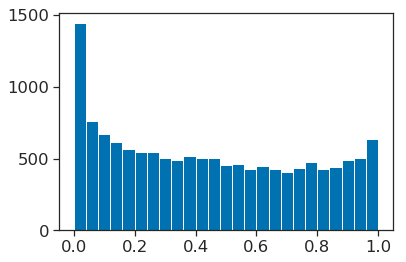

In [11]:
plt.hist(vir1_pa_dists.ks_p_val, bins=25)
plt.show()

In [12]:
def bam_cigar_to_invs(aln):
    invs = []
    start = aln.reference_start
    end = aln.reference_end
    strand = '-' if aln.is_reverse else '+'
    left = start
    right = left
    aln_length = 0
    for op, ln in aln.cigar:
        if op in (1, 4, 5):
            # does not consume reference
            continue
        elif op in (0, 2, 7, 8):
            # consume reference but do not add to invs yet
            right += ln
        elif op == 3:
            invs.append([left, right])
            aln_length += right - left
            left = right + ln
            right = left
    if right > left:
        invs.append([left, right])
    assert invs[0][0] == start
    assert invs[-1][1] == end
    return invs, start, end, strand


def parse_pysam_aln(aln):
    chrom = aln.reference_name
    read_id = aln.query_name
    invs, start, end, strand = bam_cigar_to_invs(aln)
    is_secondary = aln.is_secondary
    mapq = aln.mapping_quality
    return chrom, start, end, read_id, strand, invs, is_secondary, mapq


def get_gtf_gene_id(attrs):
    return re.search('gene_id \"(.*?)\";', attrs).group(1)


def get_gtf_exons(gtf_fn):
    with open(gtf_fn) as gtf:
        for record in gtf:
            record = record.strip().split('\t')
            if record[2] == 'exon':
                gene_id = get_gtf_gene_id(record[8])
                yield record[0], int(record[3]) - 1, int(record[4]), gene_id, record[6]


def parse_gtf_flat_exon_invs(gtf_fn):
    gene_cluster = []
    gtf_iter = get_gtf_exons(gtf_fn)
    curr_chrom, start, end, curr_gene_id, curr_strand = next(gtf_iter)
    gene_cluster.append([[start, end]])
    for chrom, start, end, gene_id, strand in gtf_iter:
        if gene_id != curr_gene_id:
            yield curr_gene_id, curr_chrom, curr_strand, flatten(gene_cluster)
            curr_gene_id, curr_chrom, curr_strand = gene_id, chrom, strand
            gene_cluster = []
            gene_cluster.append([[start, end]])
        else:
            gene_cluster.append([[start, end]])
    if gene_cluster:
        yield curr_gene_id, curr_chrom, curr_strand, flatten(gene_cluster)


def flatten(bundle):
    flattened = []
    all_invs = iter(sorted(it.chain(*bundle)))
    inv_start, inv_end = next(all_invs)
    for start, end in all_invs:
        if start <= inv_end:
            inv_end = max(inv_end, end)
        else:
            flattened.append([inv_start, inv_end])
            inv_start, inv_end = start, end
    if not flattened or flattened[-1] != [inv_start, inv_end]:
        flattened.append([inv_start, inv_end])
    return flattened


def intersect(inv_a, inv_b):
    a_start, a_end = inv_a
    b_start, b_end = inv_b
    if a_end < b_start or a_start > b_end:
        return 0
    else:
        s = max(a_start, b_start)
        e = min(a_end, b_end)
        return e - s


def intersect_spliced_invs(invs_a, invs_b):
    score = 0
    invs_a = iter(invs_a)
    invs_b = iter(invs_b)
    a_start, a_end = next(invs_a)
    b_start, b_end = next(invs_b)
    while True:
        if a_end < b_start:
            try:
                a_start, a_end = next(invs_a)
            except StopIteration:
                break
        elif a_start > b_end:
            try:
                b_start, b_end = next(invs_b)
            except StopIteration:
                break
        else:
            score += intersect([a_start, a_end], [b_start, b_end])
            if a_end > b_end:
                try:
                    b_start, b_end = next(invs_b)
                except StopIteration:
                    break
            else:
                try:
                    a_start, a_end = next(invs_a)
                except StopIteration:
                    break
    return score

In [13]:
def get_polya_dist(chrom, start, end, strand, bam, gene_invs=None,
                   overlap_thresh=200, gene_frac_thresh=0.2,
                   read_frac_thresh=0.25):
    if gene_invs is None:
        gene_invs = [[start, end]]
    gene_ln = sum([e - s for s, e in gene_invs])
    polya_lengths = []
    for aln in bam.fetch(chrom, start, end):
        *_, read_id, read_strand, read_invs, _, _  = parse_pysam_aln(aln)
        if strand != read_strand:
            continue
        read_ln = sum([e - s for s, e in read_invs])
        abs_overlap = intersect_spliced_invs(gene_invs, read_invs)
        read_frac = abs_overlap / read_ln
        gene_frac = abs_overlap / gene_ln
        if abs_overlap >= overlap_thresh and \
               read_frac >= read_frac_thresh and \
               gene_frac >= gene_frac_thresh:
            pa = aln.get_tag('pA')
            polya_lengths.append(pa)
    return np.array(polya_lengths)


def plot_overlayed_dists(*args, query, bins, clip, colors, title, lw=1, log=True, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))
    groups = []
    for i, group in enumerate(args):
        group_p_a = []
        for bam_fn in group:
            with pysam.AlignmentFile(bam_fn) as bam:
                p_a = get_polya_dist(*query, bam)
            group_p_a.append(p_a)
        group_p_a = np.concatenate(group_p_a)
        groups.append(group_p_a)
        if log:
            group_p_a = np.log10(group_p_a)
        sns.distplot(group_p_a, bins=bins, kde_kws=dict(clip=clip, lw=lw), hist_kws=dict(alpha=0.2), color=colors[i], ax=ax)
    ax.set_xlabel('polyA length')
    ax.set_title(title)
    return ax, groups

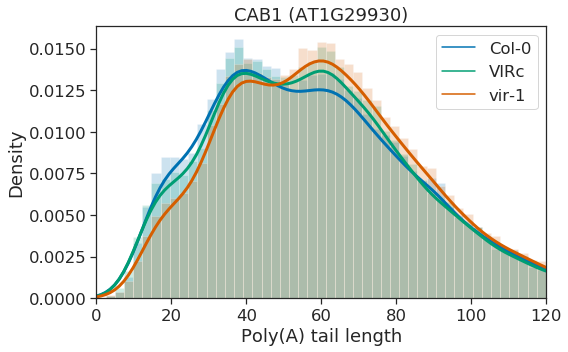

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))
_, g = plot_overlayed_dists(
    glob('../*Col*/aligned_data/*.with_pA_tag.bam'),
    glob('../*VIR*/aligned_data/*.with_pA_tag.bam'),
    glob('../*/aligned_data/*_vir1_*.with_pA_tag.bam'),
    query=('1', 10477885, 10479114, '+'),
    log=False,
    bins=np.linspace(0, 120, 50),
    clip=(0, 120),
    colors=[pal[0], pal[2], pal[1]],
    lw=3,
    title='CAB1 (AT1G29930)',
    ax=ax
)
ax.plot([], [], color=pal[0], label='Col-0')
ax.plot([], [], color=pal[2], label='VIRc')
ax.plot([], [], color=pal[1], label='vir-1')
ax.legend()
ax.set_xlim(0, 120)
ax.set_xlabel('Poly(A) tail length')
ax.set_ylabel('Density')
plt.tight_layout()
plt.savefig('cab1_polya_tail_length_distribution.svg')
plt.show()